In [1]:
# Imports and Function Initialization

import numpy as np
import math
from math import log2, sqrt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import scipy.stats
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate, CCXGate
from collections import deque


def get_braket_string(statevector):
    '''
    Return a beautified string for the given statevector
    '''
    num_qubits = log2(len(statevector))
    assert num_qubits.is_integer(), 'Expected a 2**n state'
    num_qubits = int(num_qubits)
    
    assert abs(np.linalg.norm(statevector) - 1) < 1e-4, 'Norm of state is too far from 1'
    
    simpler_state = []
    # discards 0 values
    for amplitude in statevector:
        if amplitude.imag == 0 and amplitude.real == 0:
            simpler_state.append(0)
        elif amplitude.imag == 0:
            simpler_state.append(amplitude.real)
        elif amplitude.real == 0:
            simpler_state.append(amplitude.imag)
        else:
            simpler_state.append(amplitude)
    
    out_str = ''
    skip_plus = False
    for index, amplitude in enumerate(simpler_state):
        if amplitude == 0:
            skip_plus = True
            continue
        
        if not skip_plus and index > 0:
            out_str += '+'

        state = format(index, f'0{num_qubits}b')
        
        # g defaults to 6 digits of precision but ignores zeros        
        out_str += f'{amplitude : g}|{state}>'
    return out_str


In [2]:
# Define global variables for quantum state
num_qubits = 3
num_states = 2**num_qubits
state_step = 1 / num_states

# Define global variables for normal distribution
mean = 0.5
std = 1/6

In [3]:
# Here you can create discretized values for ANY distribution, and it should work!

# Get the discretized value for the normal distribution
p = []
for i in range(1, num_states + 1):
    state = i * state_step
    p.append(scipy.stats.norm.cdf(state, mean, std) - scipy.stats.norm.cdf(state - state_step, mean, std))

print(p)

[np.float64(0.010874574623414603), np.float64(0.05458272861381337), np.float64(0.15982015110801012), np.float64(0.2733726476231318), np.float64(0.27337264762313174), np.float64(0.15982015110801018), np.float64(0.054582728613813414), np.float64(0.010874574623414568)]


In [ ]:
def create_circuit(p):

    # p = p[::-1]
    qc = QuantumCircuit(num_qubits)

    queue = deque()
    queue.append((p, [], 1))

    while queue:
        curr_p, curr_path, prev_sum = queue.popleft()

        if len(curr_p) == 1:
            continue
        
        mid = len(curr_p) // 2
        left_sum = sum(curr_p[:mid])
        theta = 2 * np.arccos(np.sqrt(left_sum / prev_sum))

        if len(curr_path) == 0:
            qc.ry(theta, num_qubits - 1) 
        else:
            control_qubits = [num_qubits - 1 - i for i in range(len(curr_path))]  
            not_gates = []
            for i in range(len(curr_path)):
                if curr_path[i]:
                    not_gates.append(control_qubits[i])
            qc.x(not_gates) if not_gates else None
            qc.append(RYGate(theta).control(len(curr_path)), 
                      control_qubits + [num_qubits - 1 - len(curr_path)])  
            qc.x(not_gates) if not_gates else None

        qc.barrier()
        
        queue.append((curr_p[:mid], curr_path + [True], left_sum))
        queue.append((curr_p[mid:], curr_path + [False], prev_sum - left_sum))

    qc.measure_all()
    return qc

qc = create_circuit(p)
print(qc.draw(output="latex_source")) # Get LATEX code
print(qc.draw('mpl'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw \barrier[0em]{2} & \qw & \qw & \qw & \qw \barrier[0em]{2} & \qw & \qw \barrier[0em]{2} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{2.302})} & \qw \barrier[0em]{2} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.836})} & \qw \barrier[0em]{2} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.306})} & \qw \barrier[0em]{2} & \qw & \gate{\mathrm{R_Y}\,(\mathrm{0.9252})} \barrier[0em]{2} & \qw \barrier[0em]{2} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \qw & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{2.4})} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{0.7552})} & \qw & \gate{\mathrm{X}} & \ctrl{-1} & \gate{\mathrm{X}} & \qw & \qw & \ctrl{-1} & \qw & \qw & \gate{\mathrm{X}} & \ctrl{-1} & \gate{\mathrm{X}} & \qw & \ctrl{-1} & \qw & \qw & \qw & 

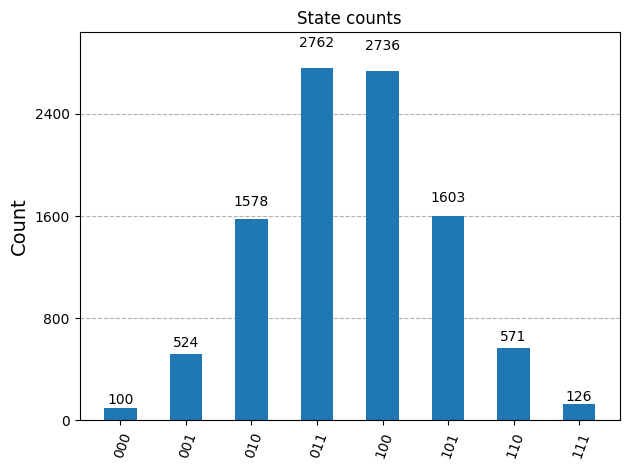

In [ ]:
from qiskit_aer import AerSimulator

simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t,shots=10000).result()
counts = result.get_counts(qc_t)
plot_histogram(counts, title='State counts')